# **1. Imports**

In [1]:
## general imports 
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

## model imports 
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.tensorboard
import torchvision
import torchvision.transforms
import sklearn.model_selection as model_selection
from torch.nn import functional as F

## observing data 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from glob import glob
from IPython.display import clear_output

# **2. Dataset**

## 2.a.Loading the data from the github repository

In [2]:
!git clone https://github.com/soniamartinot/MVA-Dose-Prediction.git

Cloning into 'MVA-Dose-Prediction'...
remote: Enumerating objects: 38724, done.
remote: Total 38724 (delta 0), reused 0 (delta 0), pack-reused 38724
Receiving objects: 100% (38724/38724), 77.02 MiB | 16.77 MiB/s, done.
Resolving deltas: 100% (30603/30603), done.
Updating files: 100% (39600/39600), done.


## 2.b. Data visualisation


The data is stored in the folder `/MVA-Dose-Prediction/`.

In this folder, there are 3 subfolders:

> _A `train` folder_ that contains 7800 patient folders. This is our training dataset.

> - In each patient folder, there are 4 different files.
> - The images have dimensions of (128, 128).

> _The `validation` folder_ contains the folders of 1200 patients. This is our validation dataset.

> _The `test` folder_ that contains 1200 patient folders. 

**Objectif : Predicting the radiation dose for the patients in the test folder.**

In [3]:
# the different datasets are stored in the folder MVA-Dose-Prediction
data_path_train = './MVA-Dose-Prediction/train/'
data_path_validation = './MVA-Dose-Prediction/validation/'
data_path_test = './MVA-Dose-Prediction/test/'

In [4]:
# Inside of the train folder
print("Number of patients in the train folder:\n", len(os.listdir(data_path_train)))
print("Number of patients in the test folder:\n", len(os.listdir(data_path_test)))
print("Number of patients in the validation folder:\n", len(os.listdir(data_path_validation)))

patient = 'sample_5295'
print("Content of a patient's folder:\n", os.listdir(data_path_train + patient))

Number of patients in the train folder:
 7800
Number of patients in the test folder:
 1200
Number of patients in the validation folder:
 1200
Content of a patient's folder:
 ['structure_masks.npy', 'possible_dose_mask.npy', 'dose.npy', 'ct.npy']


Each patient folder contains 4 `.npy` files:

- `structure_masks` (10 x 128 x 128)
- `possible_dose_mask` (128 x 128)
- `ct` (128 x 128)
- `dose` (128 x 128) (True label to predict)

ct.npy
 **************** 
possible_dose_mask.npy
 **************** 
dose.npy
 **************** 


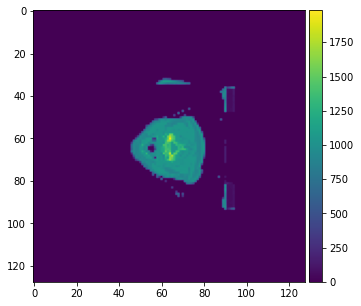

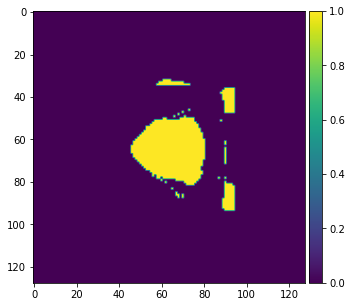

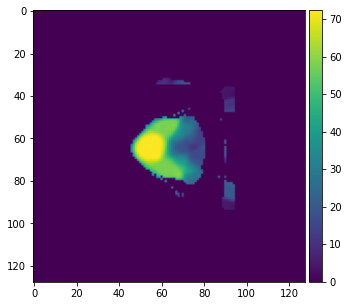

In [ ]:
# We dispay the files in the patient sample_5296

def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

def display_image(image):
  fig, ax = fig_ax()
  im = ax.imshow(image)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax)
  plt.plot()
  

files = ['ct.npy','possible_dose_mask.npy', 'dose.npy']
for file in files:
    print(file)
    image = np.load('./MVA-Dose-Prediction/train/sample_5296/' + file)
    display_image(image)
    print( ' **************** ')

# **3.Model** 

## 3.a. Global model Presentation

In this section, we will implement and train a [**UNet**](https://arxiv.org/pdf/1505.04597.pdf). UNets are particularly used for segmentation tasks in medical imaging. And can also be adatped to a regression task such as radiation dose prediction.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)




## 3.b. Network Creation 

### **i. Building blocks**

In [ ]:
## Activation function
def get_activation(activation_type):
  """ This implement an activation fonction """
  activation_type = activation_type.lower()
  if hasattr(nn, activation_type):  return getattr(nn, activation_type)()
  else:  return nn.ReLU()

In [ ]:
## ConBatchNorm block
class ConvBatchNorm(nn.Module):
    """ This block implements Convolution + BatchNorm + Activation"""  
    def __init__(self, in_channels, out_channels, activation='ReLU'):
        super(ConvBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=3, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.activation = get_activation(activation)
      
    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        return self.activation(out)

In [ ]:
## Resblock 
class ResBlock(nn.Module):
    """ This block implements a Residual Block"""
    def __init__(self, in_channels, out_channels, activation='ReLU'):
        super(ResBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.activation = get_activation(activation)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels))
      
    def forward(self, x):
        out = self.bn1(x)  
        out = self.activation(out) # pre-activation version
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.conv2(out)
        out += self.shortcut(x)
        return out

In [ ]:
## Conv layers
def _make_nConv(in_channels, out_channels, nb_Conv, activation='ReLU'):
    """ This function implements a sequence of ConvBatchNorm layers """
    layers = []
    layers.append(ConvBatchNorm(in_channels, out_channels, activation))
    for _ in range(nb_Conv-1):
        layers.append(ConvBatchNorm(out_channels, out_channels, activation))
    return nn.Sequential(*layers)

In [ ]:
### Definition of the various blocks that construct the U-net

class DownBlock(nn.Module):
    """ Downscaling with maxpooling and convolutions """
    def __init__(self, in_channels, out_channels, nb_Conv, activation='ReLU'):
        super(DownBlock, self).__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x):
        out = self.maxpool(x)
        return self.nConvs(out)  

class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, nb_Conv=2, activation='ReLU'):
        super(Bottleneck, self).__init__()
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, input):
        out = self.nConvs(input)

        return out

class UpBlock(nn.Module):
    """ Upscaling then convolution """
    def __init__(self, in_channels, out_channels, nb_Conv=2, activation='ReLU'):
        super(UpBlock, self).__init__()        
        self.up = nn.Upsample(scale_factor=2)
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x, skip_x):
        out = self.up(x)
        x = torch.cat([out, skip_x], dim=1) # dim 1 is the channel dimension
        return self.nConvs(x)

### **ii. Unet architecture**

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels=12, n_classes=1):
        '''
        n_channels : number of channels of the input. 
                        By default 12, because of the shape of our input
        n_labels : number of channels of the ouput.
                      By default 1 because it's a regression task (we predict dose radiation)
        '''
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = ResBlock(n_channels,64, activation='LeakyReLU')

        ### Encoder 
        self.down1 = DownBlock(64, 128, nb_Conv=2)
        self.down2 = DownBlock(128, 256, nb_Conv=2)
        self.down3 = DownBlock(256, 512, nb_Conv=2)
        self.down4 = DownBlock(512, 1024, nb_Conv=2)
        self.down5 = DownBlock(1024, 1024, nb_Conv=2)

        self.Encoder = [self.down1, self.down2, self.down3,self.down4,self.down5]

        ### Bottleneck
        self.bottleneck = Bottleneck(1024, 1024)

        ### Decoder 
        self.up1 = UpBlock(2048, 512, nb_Conv=2)
        self.up2 = UpBlock(1024, 256, nb_Conv=2)
        self.up3 = UpBlock(512, 128, nb_Conv=2)
        self.up4 = UpBlock(256, 64, nb_Conv=2)
        self.up5 = UpBlock(128, 64, nb_Conv=2)

        self.Decoder = [self.up1,self.up2, self.up3,self.up4,self.up5]

        self.outc = nn.Sequential(
                                  nn.Conv2d(64, self.n_classes, kernel_size=3, stride=1, padding=1)
                                  )
        self.last_activation = get_activation('ReLU')

    
    def forward(self, x):
        # Forward 
        x = self.inc(x) 
        skip_inputs = [x]
        # Forward through encoder
        for i, block in enumerate(self.Encoder):
            x = block(x)  
            skip_inputs += [x] 
            x = F.dropout(x, p=0.5, training=self.training)           

        # We are at the bottleneck.
        bottleneck = self.bottleneck(x)
        bottleneck = F.dropout(bottleneck, p=0.5, training=self.training)
        
        # Forward through decoder
        skip_inputs.reverse()
        decoded = bottleneck
        for i, block in enumerate(self.Decoder):
            # Concat with skipconnections
            skipped = skip_inputs[i+1]
            decoded = block(decoded, skipped)
            decoded = F.dropout(decoded, p=0.5, training=self.training)
        out = self.last_activation(self.outc(decoded))
        return out

##3.c. Test of the Model : 

> In order to study and potentially debug the neural network, we try to input a random tensor of size `(1, 12, 128, 128)` (batch size, number of modalities, image shape) to the model using the `torch.rand` function.

> We also check that the output dimensions of the neural network match the expected dimensions (1, 1, 128, 128).

> We also display the details of the network architecture to make sure that no errors have been made.

In [ ]:
model = UNet(n_channels=12, n_classes=1)
print(model)

# Image of size 1*12*128*128
x = torch.rand((1, 12, 128,128))
y = model(x)
print(y.shape)
print(y)

UNet(
  (inc): ResBlock(
    (conv1): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(12, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down1): DownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (nConvs): Sequential(
      (0): ConvBatchNorm(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (1): ConvBatchNorm(
 

# **4. Dataset Generation for the network**

In [ ]:
# Creation of a list of patient names / identifiers for each data record (Train, validation,test)
train_ID=os.listdir(data_path_train)
validation_ID=os.listdir(data_path_validation)
test_ID=os.listdir(data_path_test)

## 4.a. Dataset class :

> We create a custom dataset so that we can train our U-Net on it. To do this, we need to implement three methods in the PredictionDataset class: __init__, __len__, and __getitem__.

> The __init__ method is executed once during the instantiation of the Dataset object.

> The __len__ method returns the number of samples in our dataset.

> The __getitem__ method loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the location of the image on disk, converts it to a tensor, retrieves the corresponding label, calls transformation functions (if applicable), and returns the image tensor and corresponding label.

In [ ]:
class PredictionDataset(torch.utils.data.Dataset):
    'Generates data for torch'

    def __init__(self, files_list, data_path, transform=None):
        super(PredictionDataset, self).__init__()
        self.files_list = files_list
        self.transform = transform
        self.data_path = data_path

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, idx):
        'Get a patient given idx'
        patient = self.files_list[idx]

        irm, mask = self.load(patient)
        sample = (irm, mask)

        # Apply data transformation
        if self.transform:
            irm, mask = self.transform(sample)
        return (irm, mask, patient)

    def load(self, ID):
        'Load the data given a patient idx'
        patient = ID
        patient_path = os.path.join(self.data_path, patient)

        # Get all modalities for the given patient
        irm = []
        u=np.load(os.path.join(patient_path,'structure_masks.npy'))
        for k in range(len(u)):
          irm.append(u[k])
        irm.append(np.load(os.path.join(patient_path,'possible_dose_mask.npy')))
        irm.append(np.load(os.path.join(patient_path,'ct.npy')))
        irm = np.stack(irm, axis=0)

        mask= np.array([np.load(os.path.join(patient_path,'dose.npy'))])
        return irm, mask

## 4.b. `PredictionDataset` Instances :

In [ ]:
from torchvision import transforms 


transformation= []

train_Dataset = PredictionDataset(train_ID, data_path=data_path_train,
                                    transform=transformation
                                    )

val_Dataset = PredictionDataset(validation_ID, data_path=data_path_validation,
                                  transform=transformation
                                  )

test_Dataset = PredictionDataset(test_ID, data_path=data_path_test,
                                  transform=None
                                  )

In [ ]:
input_modalities, mask, patient = train_Dataset[0]

In [ ]:
print("Shape of the input:", input_modalities.shape)
print("Patient identification:", patient)

## 4.c. `DataLoader` Creation

Here we define the size of our training batches. We choose batch_size = 32.

In [ ]:
# Define the batch size
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_Dataset, 
                                           batch_size=batch_size, shuffle=True,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(val_Dataset,
                                         batch_size=batch_size, drop_last=True) 

test_loader = torch.utils.data.DataLoader(test_Dataset,
                                         batch_size=1, drop_last=False)

# **5. Utility function**



In [ ]:
def save_checkpoint(state, save_path):
    '''
        Save the current model. 
        If the model is the best model since beginning of the training
        it will be copy
    '''

    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    epoch = state['epoch']
    val_loss = state['val_loss']
    filename = save_path + '/' + \
        'model.{:02d}--{:.3f}.pth.tar'.format(epoch, val_loss)
    torch.save(state, filename)

def print_summary(epoch, i, nb_batch, loss, batch_time, 
                  average_loss, average_time, mode):
    '''
        mode = Train or Test
    '''
    summary = '[' + str(mode) + '] Epoch: [{0}][{1}/{2}]\t'.format(
        epoch, i, nb_batch)

    string = ''
    string += ('MAE Loss {:.4f} ').format(loss)
    string += ('(Average {:.4f}) \t').format(average_loss)
    string += ('Batch Time {:.4f} ').format(batch_time)
    string += ('(Average {:.4f}) \t').format(average_time)

    summary += string
    print(summary)

In [ ]:
# Definition of the different metrics
import math
import pandas as pd

def mae(y_true, predictions):
  ''' Compute the MAE loss  '''
  return np.mean(np.abs(y_true - predictions))

def mse(actual, predicted):
  ''' Compute the MSE loss  '''
  differences = np.subtract(actual, predicted)
  squared_differences = np.square(differences)
  return squared_differences.mean()

def rmse(actual, predicted):
  ''' Compute the RMSE loss  '''
  differences = np.subtract(actual, predicted)
  squared_differences = np.square(differences)
  return math.sqrt(squared_differences.mean())

def evalAllSample(mask , gt):
    '''
    This functions takes as input two numpy arrays and calculate the metrics MAE,MSE and RMSE
    '''
    wt_metrics = [mae(mask , gt),mse(mask , gt),rmse(mask, gt)]
    return pd.DataFrame({'wt': wt_metrics}, index=['MAE', 'MSE', 'RMSE'])

In [ ]:
def predict(load, model):
  ''' Predict the dose with a given model and a given load of size 12*128*128  '''
  irm= torch.from_numpy(load).float().cuda()
  image1=model(irm).cpu()
  image1=image1.detach().numpy()
  pred=image1[0][0]
  return pred

def re_construct(patient_path):
  ''' Construct a compatible input for the model given a patient_path  '''
  irm = []
  u=np.load(os.path.join(patient_path,'structure_masks.npy'))
  for k in range(len(u)):
    irm.append(u[k])
  irm.append(np.load(os.path.join(patient_path,'possible_dose_mask.npy')))
  irm.append(np.load(os.path.join(patient_path,'ct.npy')))
  irm = np.stack(irm, axis=0)
  irm=np.array([irm])
  return irm

In [ ]:
# Train the model
def train_loop(loader, model, criterion, optimizer, writer, epoch):

    logging_mode = 'Train' if model.training else 'Val'
    if model.training:print('training')
    
    epoch_time_sum, epoch_loss_sum = [], []
    
    for i, sample in enumerate(loader, 1):
        start = time.time()
        # Take variable 
        (irms, masks, patients) = sample 
        # print(irms.shape) # Batch * Number of Modalities * Width * Height
        
        # Put variables to GPU
        irms = irms.float().cuda()
        masks = masks.float().cuda()
    
        # compute model prediction
        pred_masks = model(irms)

        # compute loss
        mae_loss = criterion(pred_masks, masks) 

        # If in training mode ...
        if model.training:
            # Initialize optimizer gradients to zero
            optimizer.zero_grad()
            # Perform backpropagation
            mae_loss.backward()
            # Update the model's trainable parameters using the computed gradients
            optimizer.step()

        # Compute elapsed time
        batch_time = time.time() - start

        epoch_time_sum += [batch_time]
        epoch_loss_sum += [mae_loss.item()]
        
        average_time = np.mean(epoch_time_sum)
        average_loss = np.mean(epoch_loss_sum)
        
        if i % print_frequency == 0:
            print_summary(epoch + 1, i, len(loader), mae_loss, batch_time,
                          average_loss, average_time, logging_mode)
        step = epoch*len(loader) + i
        writer.add_scalar(logging_mode + '_mae', mae_loss.item(),step)
            
            

    writer.add_scalar(logging_mode + '_global_loss', np.mean(epoch_loss_sum), epoch)
    return np.mean(epoch_loss_sum)

# **6. Training**

## 6.a Training from scratch 

In [ ]:
batch_size = 32
n_modalities = 12
n_classes = 1
learning_rate = 1e-4
criterion = nn.L1Loss() 
epochs = 2 ##100
print_frequency = 10
save_frequency = 1
save_model = True
weight_decay = 1e-5

In [ ]:
torch.cuda.empty_cache()
model = UNet(n_channels=n_modalities, n_classes=n_classes) # Create model

model.cuda() # move model to GPU
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Choose optimize

In [ ]:
save_path = "./MVA-Dose-Prediction/saveA/"
session_name = 'Test_session' + '_' + time.strftime('%m.%d %Hh%M')
model_path = save_path + 'models/' + session_name + '/'
# Start tensorboard
session_name = 'Test_session' + '_' + time.strftime('%m.%d %Hh%M')
tensorboard_folder = save_path + 'tensorboard_logs/'
log_dir = tensorboard_folder + session_name + '/'
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
writer = torch.utils.tensorboard.SummaryWriter(log_dir)

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times
    print('******** Epoch [{}/{}]  ********'.format(epoch+1, epochs+1))
    print(session_name)

    # train for one epoch
    model.train()
    print('Training')
    train_loop(train_loader, model, criterion, optimizer, writer, epoch)

    # evaluate on validation set
    print('Validation')
    with torch.no_grad():   
        model.eval()        
        val_loss = train_loop(val_loader, model, criterion, optimizer, writer, epoch)

    if save_model and epoch > epochs -2 :
        save_checkpoint({'epoch': epoch,
                        'state_dict': model.state_dict(),
                         'val_loss': val_loss,
                         'optimizer': optimizer.state_dict()}, model_path)

******** Epoch [1/3]  ********
Test_session_03.26 17h52
Training
training
[Train] Epoch: [1][10/243]	MAE Loss 2.7760 (Average 2.8529) 	Batch Time 0.2478 (Average 0.2634) 	
[Train] Epoch: [1][20/243]	MAE Loss 2.3164 (Average 2.7266) 	Batch Time 0.2473 (Average 0.2558) 	
[Train] Epoch: [1][30/243]	MAE Loss 2.6020 (Average 2.6917) 	Batch Time 0.2472 (Average 0.2533) 	
[Train] Epoch: [1][40/243]	MAE Loss 2.4724 (Average 2.6408) 	Batch Time 0.2507 (Average 0.2520) 	
[Train] Epoch: [1][50/243]	MAE Loss 2.4875 (Average 2.5925) 	Batch Time 0.2492 (Average 0.2515) 	
[Train] Epoch: [1][60/243]	MAE Loss 1.9366 (Average 2.5387) 	Batch Time 0.2501 (Average 0.2511) 	
[Train] Epoch: [1][70/243]	MAE Loss 2.0905 (Average 2.5034) 	Batch Time 0.2508 (Average 0.2510) 	
[Train] Epoch: [1][80/243]	MAE Loss 1.6794 (Average 2.4604) 	Batch Time 0.2504 (Average 0.2508) 	
[Train] Epoch: [1][90/243]	MAE Loss 2.2989 (Average 2.4214) 	Batch Time 0.2511 (Average 0.2507) 	
[Train] Epoch: [1][100/243]	MAE Loss 1.9319 

## 6.b Training from previous weights

In [ ]:
torch.cuda.empty_cache()
model = UNet(n_channels=n_modalities, n_classes=n_classes) # Create model
model.cuda() # move model to GPU
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Choose optimizer
checkpoint = torch.load('/content/MVA-Dose-Prediction/saveA/models/Test_session_03.20 19h43/model.04--0.537.pth.tar') # load model
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['val_loss']

In [ ]:
batch_size = 32
n_modalities = 12
n_classes = 1
learning_rate = 1e-4
criterion = nn.L1Loss() 
epochs = 10
print_frequency = 10
save_frequency = 1
save_model = True
weight_decay = 1e-4

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times
    print('******** Epoch [{}/{}]  ********'.format(epoch+1, epochs+1))
    print(session_name)

    # train for one epoch
    model.train()
    print('Training')
    train_loop(train_loader, model, criterion, optimizer, writer, epoch)

    # evaluate on validation set
    print('Validation')
    with torch.no_grad():  
        model.eval()       
        val_loss = train_loop(val_loader, model, criterion, optimizer, writer, epoch)

    # if save_model and epoch % save_frequency == 0:
    if save_model and epoch > epochs -2 :
        save_checkpoint({'epoch': epoch,
                        'state_dict': model.state_dict(),
                         'val_loss': val_loss,
                         'optimizer': optimizer.state_dict()}, model_path)

# **7.Prediction and evalutation**

After training the model, we need to perform two steps:
 

1.  Use the trained model to predict a dose.
 
2.  Evaluate the performance of the network on the validation set


In [ ]:
val_path = './MVA-Dose-Prediction/validation/'
patients = [os.path.basename(p) for p in glob(val_path + "*")]

In [ ]:
# Load a saved model (Can be found in the save/model folder
checkpoint = torch.load('/content/MVA-Dose-Prediction/saveA/models/Test_session_03.20 16h11/model.04--0.785.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

## 7.a Visualisation of one exemple : 

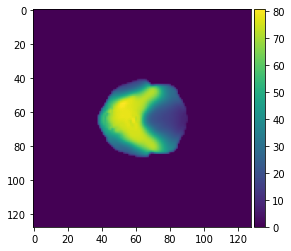

In [ ]:
patient_path= '/content/MVA-Dose-Prediction/validation/sample_8496'
irm = []
u=np.load(os.path.join(patient_path,'structure_masks.npy'))
for k in range(len(u)):
  irm.append(u[k])
irm.append(np.load(os.path.join(patient_path,'possible_dose_mask.npy')))
irm.append(np.load(os.path.join(patient_path,'ct.npy')))
irm = np.stack(irm, axis=0)
irm=np.array([irm])
irm= torch.from_numpy(irm).float().cuda()
image1=model(irm).cpu()
image1=image1.detach().numpy()
image=image1[0][0]
ax = plt.subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(image)
plt.colorbar(im, cax=cax)
plt.show()

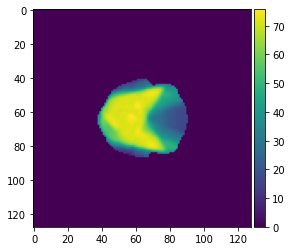

In [ ]:
imaget = np.load('./MVA-Dose-Prediction/validation/sample_8496/dose.npy')
ax = plt.subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(imaget)
plt.colorbar(im, cax=cax)
plt.show()

In [ ]:
# We calculate the mae between the predicted dose and the true dose.npy image
print(mae(imaget,image))

0.8747356701547105


## 7.b Metrics computation on all validation 

In [ ]:
mae_list = []
mse_list = []
rmse_list = []

for patient in patients:
    # Path to original image
    patient_folder = os.path.join(val_path,patient)
    # Open image
    predict_mask= re_construct(patient_path=patient_folder)
    predict_mask=predict(predict_mask,model)

    orig = os.path.join(patient_folder, 'dose.npy')
    # Convert image to numpy array
    orig_mask = np.load(orig)
    
    # print('*********** {} ***********'.format(patient))
    scores = evalAllSample(predict_mask, orig_mask)
    # print(scores)
    # print("\n")

    mae_list.append(scores.loc['MAE', 'wt'])
    mse_list.append(scores.loc['MSE', 'wt'])
    rmse_list.append(scores.loc['RMSE', 'wt'])

In [ ]:
# We evaluate the model on the entire validation dataset :
print('MAE on the validation set : {:.2f}'.format(np.mean(mae_list)))
print('MSE on the validation set : {:.2f}'.format(np.mean(mse_list)))
print('RMSE on the validation set : {:.2f}'.format(np.mean(rmse_list)))

MAE on the validation set : 0.70
MSE on the validation set : 9.77
RMSE on the validation set : 2.87


## 7.c Answer Folder generation 

In [ ]:
## mounting drive will make the download of the answer folder easier
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
test_path = './MVA-Dose-Prediction/test/'
patient1 = [os.path.basename(p) for p in glob(test_path + "*")]

In [ ]:
# Creation of a folder with the answers
save_path1 = "./MVA-Dose-Prediction/Answers/"
if not os.path.isdir(save_path1):
    os.makedirs(save_path1)

for patient in patient1:
    # Path to original image
    patient_folder = os.path.join(test_path,patient)
    # Open image
    predict_mask= re_construct(patient_path=patient_folder)
    predict_mask=predict(predict_mask,model)
    np.save(os.path.join(save_path1,patient), predict_mask)

In [ ]:
# We check the content of the new folder Answers
imaget = np.load('./MVA-Dose-Prediction/Answers/sample_10012.npy')
ax = plt.subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(imaget)
plt.colorbar(im, cax=cax)
plt.show()

In [ ]:
## to load in the gdrive 
!cp -r ./MVA-Dose-Prediction/Answers /content/gdrive/My\ Drive/

## **8. Annexe**

## 8.a Data Augmentation Test 

In [ ]:
irms, masks, patient = next(iter(val_loader))

irm = irms[0,:].numpy()
mask = masks[0,:].numpy()
print(irm.shape)
print(mask.shape)
print(patient)

(12, 128, 128)
(1, 128, 128)
('sample_8094', 'sample_8476', 'sample_8908', 'sample_8416', 'sample_8690', 'sample_8117', 'sample_8159', 'sample_7813', 'sample_7861', 'sample_8167', 'sample_8061', 'sample_8067', 'sample_8213', 'sample_8897', 'sample_8246', 'sample_8505', 'sample_8604', 'sample_8564', 'sample_8524', 'sample_8721', 'sample_8253', 'sample_8862', 'sample_8894', 'sample_8098', 'sample_8579', 'sample_8183', 'sample_8487', 'sample_8786', 'sample_8346', 'sample_8047', 'sample_8554', 'sample_7869')


In [ ]:
import scipy
import scipy.ndimage
import numpy as np

class AxialFlip(object):

    def __call__(self, sample):
        choice_x = np.random.randint(0, 2)
        choice_y = np.random.randint(0, 2)        
        irm, mask = sample
        new_sample = (self.axialflip(irm, choice_x, choice_y),
                      self.axialflip(mask, choice_x, choice_y))
        return new_sample

    def axialflip(self, array, choice_x, choice_y):
        if choice_x == 1:  array = array[:, ::-1, :]
        if choice_y == 1:  array = array[:, ::-1, ::-1]
        return np.ascontiguousarray(array)

class RandomRotation90(object):
    '''
        Taken from augment_rot90 from MIC-DKFZ/batchgenerators
        https://github.com/MIC-DKFZ/batchgenerators/blob/master/batchgenerators/augmentations/spatial_transformations.py
    '''

    def __init__(self, num_rot=(1, 2, 3, 4)):
        self.num_rot = num_rot
        self.axes = (1,2)

    def __call__(self, sample):
        '''
          irm and mask have shape (Modality*Width*Height) and (Label*Width*Height)
        '''
        num_rot = np.random.choice(self.num_rot)        
        def f(img):
            return np.ascontiguousarray(np.rot90(img, num_rot, self.axes))
        
        irm, mask = sample
        new_sample = (f(irm), f(mask))
        return new_sample

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, cubic crop
            is made.
    """
    def __init__(self, output_size, dim=2):
        assert isinstance(output_size, (int, tuple, list))
        if isinstance(output_size, int):
            self.output_size = dim * (output_size,)
        else:
            assert len(output_size) == dim
            self.output_size = output_size  

    def __call__(self, sample):        
        irm, mask = sample        
        _, height, width = irm.shape    
        i = np.random.randint(0, height - self.output_size[0])
        j = np.random.randint(0, width - self.output_size[1])

        def f(img):
            return img[:, i: i + self.output_size[0], j : j + self.output_size[1]]

        new_sample = ( f(irm), f(mask))
        return new_sample

def RandomTranslation(max_translation=30, transform_matrix=None, debug=False):    
    translation = np.random.randint(-max_translation, max_translation, 2)    
    if debug:
        return getTranslationMatrix(translation, transform_matrix), (translation)
    else:
        return getTranslationMatrix(translation, transform_matrix)
    
def RandomRotation(theta_max=20, transform_matrix=None, debug=False):    
    theta = np.random.uniform(-theta_max, theta_max)
    if debug:
        return getRotationMatrix(theta, transform_matrix), theta
    else:
        return getRotationMatrix(theta, transform_matrix)

def RandomZoom(zoom_max=0.2, transform_matrix=None, debug=False):  
    zoom = np.random.uniform(1 - zoom_max, 1 + zoom_max)
    if debug:
          return getZoomMatrix(zoom, transform_matrix), zoom
    else:
        return getZoomMatrix(zoom, transform_matrix)

def getTranslationMatrix(translation, transform_matrix=None):
    '''
        2D translation on the axis (0, 1). 
        Axis 3 is the modality axis
        tx: Width shift.
        ty: Heigh shift.
    
    '''
    shift_matrix = np.array([[1, 0, translation[0]],
                            [0, 1, translation[1]],
                            [0, 0, 1]])

    if transform_matrix is None:
        transform_matrix = shift_matrix
    else:
        transform_matrix = np.dot(transform_matrix, shift_matrix)            
    return transform_matrix

def getZoomMatrix(zoom, transform_matrix=None):
    '''
        Affine Zoom in 2D
        zx: Zoom in x direction.
        zy: Zoom in y direction
    '''
    zoom_matrix = np.array([[zoom, 0, 0],
                            [0, zoom, 0],
                            [0, 0, 1]])
    if transform_matrix is None:
        transform_matrix = zoom_matrix
    else:
        transform_matrix = np.dot(transform_matrix, zoom_matrix)            
    return transform_matrix

def getRotationMatrix(theta, transform_matrix=None):
    '''
        2D rotation on the axis (0, 1). 
        Axis 3 is the modality axis
        theta: Rotation angle in degrees.
    '''
    theta = np.deg2rad(theta)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    if transform_matrix is None:
        transform_matrix = rotation_matrix
    else:
        transform_matrix = np.dot(transform_matrix, rotation_matrix)
    return transform_matrix


def apply_affine_transform(x, seg=None, transform_matrix=None, crop_shape=None, 
                           fill_mode='nearest', cval=0., order=3):
    """Applies an affine transformation specified by the parameters given.
    # Arguments
        x: 4D numpy array, single image, multimodalities (Modality*H*W)
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
        order: int, order of interpolation
    # Returns
        The transformed version of the input.
    """
    if scipy is None:
        raise ImportError('Image transformations require SciPy. '
                          'Install SciPy.')
    if transform_matrix is not None:        
        channels, h, w = x.shape                
        transform_matrix = transform_matrix_offset_center(transform_matrix, 
                                                          h, w)
        res = [ scipy.ndimage.affine_transform(x[channel, ...], transform_matrix,
                                              order=order, mode=fill_mode, cval=cval)  for channel in range(channels)]
        x = np.stack(res, axis=0)
        
        if seg is not None:            
            labels = seg.shape[0]
            res = [scipy.ndimage.affine_transform(seg[label, ...], transform_matrix,
                                                                order=order, mode=fill_mode, cval=cval) for label in range(labels)]
            seg = np.stack(res, axis=0)
            seg[seg > 0.5] = 1
            seg[seg < 0.5] = 0
            return x, seg         
    return x

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], 
                              [0, 1, o_y],
                              [0, 0, 1]])    
    reset_matrix = np.array([[1, 0, -o_x], 
                             [0, 1, -o_y],
                             [0, 0, 1]])    
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

class AffineTransform(object):
    
    def __init__(self, theta=0, max_translation=0, max_zoom=0):
        self.theta = theta
        self.max_translation = max_translation
        self.max_zoom = max_zoom
        
    def __call__(self, sample):        
        transform_matrix = np.eye(3)
        if self.theta > 0:
            transform_matrix = RandomRotation(self.theta)
        if self.max_translation > 0:
            transform_matrix = RandomTranslation(self.max_translation,
                                                 transform_matrix)
        if self.max_zoom > 0:
            transform_matrix = RandomZoom(self.max_zoom,
                                          transform_matrix)
        new_irm, new_mask = apply_affine_transform(irm, mask, transform_matrix)
        return (new_irm, new_mask)

In [ ]:
transforms_list = [AxialFlip(), RandomRotation90()]
batch_size = 32

transformation = torchvision.transforms.Compose(transforms_list)


train_Dataset = PredictionDataset(train_ID, data_path=data_path_train,
                                    transform=transformation
                                    )

val_Dataset = PredictionDataset(validation_ID, data_path=data_path_validation,
                                  transform=transformation
                                  )

test_Dataset = PredictionDataset(test_ID, data_path=data_path_test,
                                  transform=None
                                  )

train_loader_data_augment = torch.utils.data.DataLoader(train_Dataset, 
                                           batch_size=batch_size, shuffle=True,
                                           drop_last=True)

val_loader_data_augment = torch.utils.data.DataLoader(val_Dataset,
                                         batch_size=batch_size, drop_last=True) 

test_loader_data_augment = torch.utils.data.DataLoader(test_Dataset,
                                         batch_size=1, drop_last=False)

## 8.b Add Resblock instead of ConvBatchNorm

In [ ]:
## Replace the _make_nConv by this function in the blocks (mostly Downblock)

def _make_nRes(in_channels, out_channels, nb_Conv, activation):
    layers = [ResBlock(in_channels, out_channels, activation)]
    for _ in range(nb_Conv - 1):
        layers.append(ResBlock(out_channels, out_channels, activation))
    return nn.Sequential(*layers)